In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
sklearn.set_config(transform_output="pandas")
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from mlxtend.regressor import StackingCVRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet, Lasso, ElasticNetCV
import optuna
import joblib
import xgboost as xgb
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from scipy import stats

In [38]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
submission = pd.read_csv('sample_submission.csv')

In [39]:
all_data = pd.concat((test.loc[:,:], train.loc[:, :]))
all_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,NaN
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,NaN
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,NaN
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,NaN
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,NaN


In [40]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: ylabel='SalePrice'>

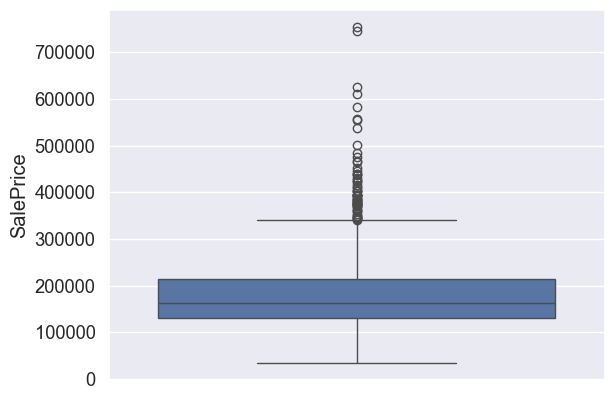

In [41]:
sns.boxplot(train['SalePrice'])

/var/folders/db/69n9mbnx1hn26gcpf46v9d8h0000gn/T/ipykernel_48000/4257204882.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['SalePrice'])


<Axes: xlabel='SalePrice', ylabel='Density'>

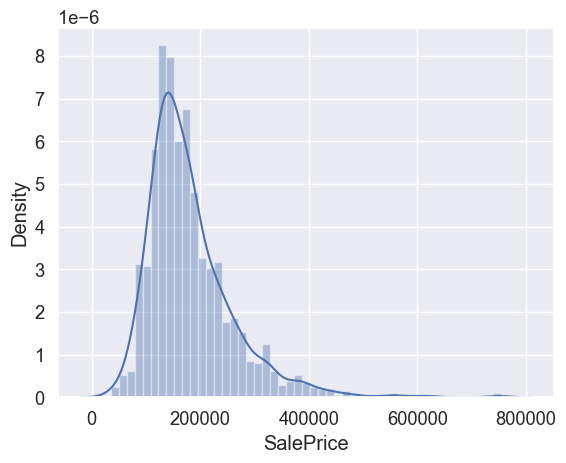

In [42]:
sns.distplot(train['SalePrice'])

In [43]:
train['SalePrice'] = np.log1p(train['SalePrice'])

In [44]:
y_train = train['SalePrice']
y_train

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1460, dtype: float64

/var/folders/db/69n9mbnx1hn26gcpf46v9d8h0000gn/T/ipykernel_48000/1637237975.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train["SalePrice"])


<Axes: xlabel='SalePrice', ylabel='Density'>

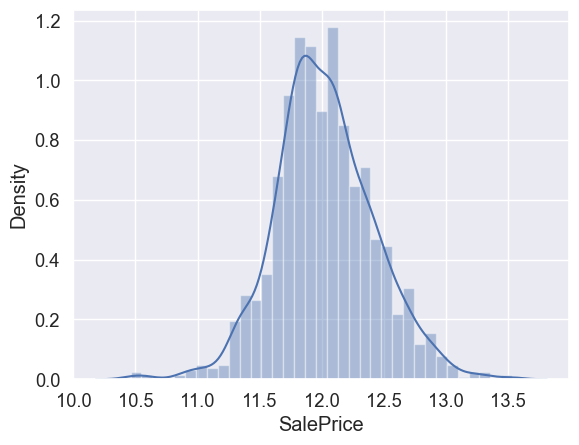

In [45]:
sns.distplot(train["SalePrice"])

In [46]:
train = train.drop("Id", axis=1)
test = test.drop("Id", axis=1)

In [47]:
train = train.drop(["Street", "Utilities"], axis=1)
test = test.drop(["Street", "Utilities"], axis=1)
#Because contains only one value

Text(0.5, 1.0, 'GrLivArea vs SalePrice')

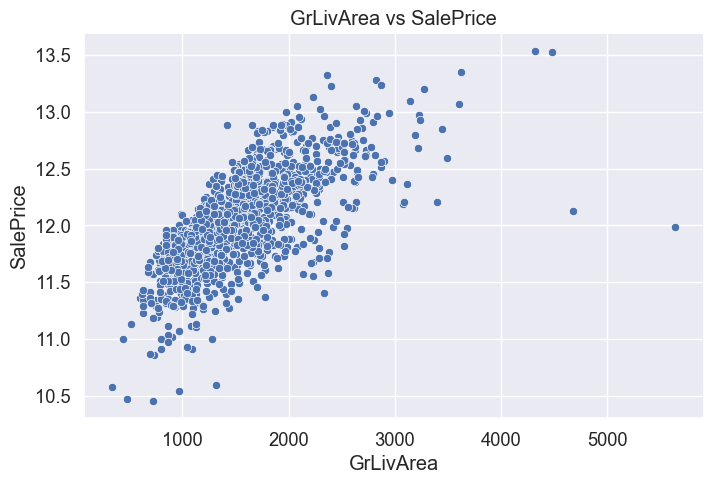

In [48]:
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
sns.scatterplot(x=train["GrLivArea"], y=train["SalePrice"])
plt.title("GrLivArea vs SalePrice")

In [49]:
clear_data = train.drop(train[(train['GrLivArea']>4500)].index)

In [50]:
clear_data

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,NaN,Reg,Lvl,Inside,Gtl,CollgCr,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247699
1,20,RL,80.0,9600,NaN,Reg,Lvl,FR2,Gtl,Veenker,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109016
2,60,RL,68.0,11250,NaN,IR1,Lvl,Inside,Gtl,CollgCr,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317171
3,70,RL,60.0,9550,NaN,IR1,Lvl,Corner,Gtl,Crawfor,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849405
4,60,RL,84.0,14260,NaN,IR1,Lvl,FR2,Gtl,NoRidge,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,NaN,Reg,Lvl,Inside,Gtl,Gilbert,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,12.072547
1456,20,RL,85.0,13175,NaN,Reg,Lvl,Inside,Gtl,NWAmes,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,12.254868
1457,70,RL,66.0,9042,NaN,Reg,Lvl,Inside,Gtl,Crawfor,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,12.493133
1458,20,RL,68.0,9717,NaN,Reg,Lvl,Inside,Gtl,NAmes,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,11.864469


In [51]:
train_ = clear_data.drop(['SalePrice'], axis=1)
all_data = pd.concat([train, test]).reset_index(drop=True)

In [52]:
all_data[all_data.GarageYrBlt > 2017].GarageYrBlt

2592    2207.0
Name: GarageYrBlt, dtype: float64

In [53]:
all_data.loc[2592, 'GarageYrBlt'] = 2007

In [54]:
all_data['LotFrontage'].isnull().sum()

np.int64(486)

In [55]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [56]:
all_data['LotFrontage'].isnull().sum()

np.int64(0)

In [57]:
#Iz numeric v categorical 
def convert_to_string(df, columns):
    df[columns] = df[columns].astype(str)
    return df

num_to_categ_features = ['MSSubClass', 'OverallCond']

all_data = convert_to_string(all_data, columns = num_to_categ_features)

In [58]:
num_features = all_data.select_dtypes(include=['int64','float64']).columns
num_features_to_constant = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', "MasVnrArea"] 
num_features_to_median = [feature for feature in num_features if feature not in num_features_to_constant + ["SalePrice"]]

In [59]:
imputer = ColumnTransformer(
    transformers = [
        ('num_to_median', SimpleImputer(strategy='most_frequent'), num_features_to_median),
        ('num_to_constant', SimpleImputer(strategy='constant', fill_value=0), num_features_to_constant),
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)

In [60]:
categorical_features = all_data.select_dtypes(include=['object']).columns

In [61]:
none_conversion = [("MasVnrType","None"),
                  ("BsmtQual","NA"), 
                  ("Electrical", "SBrkr"),
                  ("BsmtCond","TA"),
                  ("BsmtExposure","No"),
                  ("BsmtFinType1","No"),
                  ("BsmtFinType2","No"),
                  ("CentralAir","N"),
                  ("Condition1","Norm"), 
                  ("Condition2","Norm"),
                  ("ExterCond","TA"),
                  ("ExterQual","TA"), 
                  ("FireplaceQu","NA"),
                  ("Functional","Typ"),
                  ("GarageType","No"), 
                  ("GarageFinish","No"), 
                  ("GarageQual","NA"), 
                  ("GarageCond","NA"), 
                  ("HeatingQC","TA"), 
                  ("KitchenQual","TA"), 
                  ("Functional","Typ"), 
                  ("GarageType","No"), 
                  ("GarageFinish","No"), 
                  ("GarageQual","No"), 
                  ("GarageCond","No"), 
                  ("HeatingQC","TA"), 
                  ("KitchenQual","TA"),
                  ("MSZoning", "None"),
                  ("Exterior1st", "VinylSd"), 
                  ("Exterior2nd", "VinylSd"), 
                  ("SaleType", "WD")]

In [62]:
for col, new_str in none_conversion:
        all_data.loc[:, col] = all_data.loc[:, col].fillna(new_str)

In [63]:
categorical_features = all_data.select_dtypes(include=['object']).columns

In [ ]:
# all_data["TotalSqrtFeet"] = all_data["GrLivArea"] + all_data["TotalBsmtSF"]
# all_data["TotalBaths"] = all_data["BsmtFullBath"] + (all_data["BsmtHalfBath"]  * 0.5) + all_data["FullBath"] + (all_data["HalfBath"]* 0.5)

In [ ]:
# all_data['Isgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

# all_data['Isfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# all_data['Ispool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

# all_data['Issecondfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

# all_data['IsOpenPorch'] = all_data['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)

# all_data['IsWoodDeck'] = all_data['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
# categorical_features = all_data.select_dtypes(include=['object']).columns

In [ ]:
# all_data = all_data.drop(['GarageArea', 'Fireplaces', 'PoolArea', '2ndFlrSF', 'OpenPorchSF', 'WoodDeckSF',
#                           'GrLivArea', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], axis=1)

In [64]:
my_encoder = ColumnTransformer(
    transformers = [
        ('ordinal_encoding', OrdinalEncoder(), categorical_features)
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
)

In [65]:
my_scaler = ColumnTransformer(
    transformers = [
        ('scaling_num_columns', StandardScaler(), num_features)
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
)

In [66]:
preprocessor = Pipeline(
    steps= [
        ('imputer', imputer),
        ('my_encoder', my_encoder),
        ('my_scaler', my_scaler)
    ]
)

In [67]:
all_data = preprocessor.fit_transform(all_data)

In [68]:
train_preprocessed = all_data.iloc[:len(train),:]
test_preprocessed = all_data.iloc[len(train_preprocessed):,:]

In [69]:
train_preprocessed

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,-0.209359,-0.217879,0.646183,1.046258,0.896833,0.529034,0.581145,-0.293025,-0.934165,-0.443078,...,1.0,2.0,5.0,5.0,2.0,NaN,NaN,NaN,8.0,4.0
1,0.481900,-0.072044,-0.063185,0.154764,-0.395604,-0.567016,1.178255,-0.293025,-0.629284,0.477463,...,1.0,2.0,5.0,5.0,2.0,NaN,NaN,NaN,8.0,4.0
2,-0.071107,0.137197,0.646183,0.980221,0.848965,0.338903,0.098189,-0.293025,-0.287999,-0.297968,...,1.0,2.0,5.0,5.0,2.0,NaN,NaN,NaN,8.0,4.0
3,-0.439779,-0.078385,0.646183,-1.859351,-0.682812,-0.567016,-0.494529,-0.293025,-0.046824,-0.669812,...,5.0,3.0,5.0,5.0,2.0,NaN,NaN,NaN,8.0,0.0
4,0.666236,0.518903,1.355551,0.947203,0.753229,1.390216,0.469187,-0.293025,-0.160586,0.212184,...,1.0,2.0,5.0,5.0,2.0,NaN,NaN,NaN,8.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-0.347611,-0.285470,-0.063185,0.914184,0.753229,-0.567016,-0.968705,-0.293025,0.892847,-0.223146,...,1.0,2.0,5.0,5.0,2.0,NaN,NaN,NaN,8.0,4.0
1456,0.712320,0.381311,-0.063185,0.220801,0.178812,0.098443,0.765547,0.670616,0.064662,1.112319,...,1.0,3.0,5.0,5.0,2.0,NaN,2.0,NaN,8.0,4.0
1457,-0.163275,-0.142806,0.646183,-1.000876,1.040437,-0.567016,-0.365009,-0.293025,0.719929,0.228056,...,1.0,2.0,5.0,5.0,2.0,NaN,0.0,2.0,8.0,4.0
1458,-0.071107,-0.057207,-0.772552,-0.703711,0.561757,-0.567016,-0.861137,5.790328,-1.275450,0.060272,...,1.0,3.0,5.0,5.0,2.0,NaN,NaN,NaN,8.0,4.0


In [70]:
test_preprocessed

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
1460,0.481900,0.184371,-0.772552,-0.340510,-1.113625,-0.567016,0.058675,0.558290,-0.661137,-0.384127,...,1.0,3.0,5.0,5.0,2.0,NaN,2.0,NaN,8.0,4.0
1461,0.527984,0.519791,-0.063185,-0.439565,-1.257229,0.036930,1.057516,-0.293025,-0.351705,0.629375,...,1.0,3.0,5.0,5.0,2.0,NaN,NaN,0.0,8.0,4.0
1462,0.205396,0.464374,-0.772552,0.848148,0.657493,-0.567016,0.767742,-0.293025,-0.963743,-0.279829,...,1.0,0.0,5.0,5.0,2.0,NaN,2.0,NaN,8.0,4.0
1463,0.389732,-0.024109,-0.063185,0.881166,0.657493,-0.455174,0.352839,-0.293025,-0.538274,-0.284364,...,1.0,0.0,5.0,5.0,2.0,NaN,NaN,NaN,8.0,4.0
1464,-1.223206,-0.654748,1.355551,0.683057,0.370284,-0.567016,-0.391353,-0.293025,1.038461,0.518275,...,1.0,2.0,5.0,5.0,2.0,NaN,NaN,NaN,8.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,-2.237052,-1.043937,-1.481920,-0.043346,-0.682812,-0.567016,-0.968705,-0.293025,-0.033173,-1.145954,...,6.0,1.0,3.0,3.0,2.0,NaN,NaN,NaN,8.0,4.0
2915,-2.237052,-1.049263,-1.481920,-0.043346,-0.682812,-0.567016,-0.415500,-0.293025,-0.606531,-1.145954,...,4.0,3.0,5.0,5.0,2.0,NaN,NaN,NaN,8.0,0.0
2916,4.168614,1.246808,-0.772552,-0.373528,0.561757,-0.567016,1.718287,-0.293025,-1.275450,0.391304,...,5.0,3.0,5.0,5.0,2.0,NaN,NaN,NaN,8.0,0.0
2917,-0.347611,0.034605,-0.772552,0.683057,0.370284,-0.567016,-0.228904,-0.293025,0.032809,-0.316107,...,6.0,1.0,3.0,3.0,2.0,NaN,2.0,2.0,8.0,4.0


In [71]:
X_train_preprocessed = train_preprocessed.drop(columns=['SalePrice'])
X_test_preprocessed = test_preprocessed.drop(columns=['SalePrice'])

In [72]:
null_counts = X_test_preprocessed.isnull().sum()
columns_with_nulls = null_counts[null_counts > 0].index.tolist()
columns_with_nulls

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

In [95]:
# X_test_preprocessed.at[2120, 'TotalSqrtFeet'] = X_test_preprocessed['TotalSqrtFeet'].median()

In [ ]:
# X_test_preprocessed.at[2120, 'TotalBaths'] = X_test_preprocessed['TotalBaths'].median()
# X_test_preprocessed.at[2188, 'TotalBaths'] = X_test_preprocessed['TotalBaths'].median()

In [74]:
X_train_preprocessed = X_train_preprocessed.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)
X_test_preprocessed = X_test_preprocessed.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)

In [75]:
X_train, X_valid, y_train, y_valid= train_test_split(X_train_preprocessed, y_train, test_size=0.2, random_state=42)

In [76]:
def lasso_optimization(trial):
    alpha = trial.suggest_float('alpha', 1e-10, 5.0)
    lasso = Lasso(alpha=alpha, random_state=42)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_valid)
    
    rmsle = np.sqrt(mean_squared_log_error(y_valid, y_pred))
    return rmsle

In [77]:
lasso_study = optuna.create_study(direction='minimize')
lasso_study.optimize(lasso_optimization, n_trials=100)

[I 2024-07-13 11:48:17,139] A new study created in memory with name: no-name-0a014bf6-3c04-4d27-848f-a2d61b0e3edb
[I 2024-07-13 11:48:17,181] Trial 0 finished with value: 0.033362274356524425 and parameters: {'alpha': 0.9978930409205283}. Best is trial 0 with value: 0.033362274356524425.
[I 2024-07-13 11:48:17,186] Trial 1 finished with value: 0.033362274356524425 and parameters: {'alpha': 3.6921179087613827}. Best is trial 0 with value: 0.033362274356524425.
[I 2024-07-13 11:48:17,191] Trial 2 finished with value: 0.0224696903244257 and parameters: {'alpha': 0.1611640641333836}. Best is trial 2 with value: 0.0224696903244257.
[I 2024-07-13 11:48:17,201] Trial 3 finished with value: 0.033362274356524425 and parameters: {'alpha': 1.380594363388226}. Best is trial 2 with value: 0.0224696903244257.
[I 2024-07-13 11:48:17,208] Trial 4 finished with value: 0.033362274356524425 and parameters: {'alpha': 4.615804752703544}. Best is trial 2 with value: 0.0224696903244257.
[I 2024-07-13 11:48:1

In [78]:
lasso_best_params = lasso_study.best_params
best_lasso = Lasso(alpha=lasso_best_params['alpha'], random_state=42)
best_lasso.fit(X_train, y_train)

Lasso(alpha=0.006723832228594806, random_state=42)

In [79]:
selected_features = np.where(abs(best_lasso.coef_) != 0)[0]
X_train_selected = X_train.iloc[:, selected_features]
X_val_selected = X_valid.iloc[:, selected_features]
X_test_selected = X_test_preprocessed.iloc[:, selected_features]

In [80]:
def xgb_optimization(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'random_state': 42
    }

    xg_reg = xgb.XGBRegressor(**param)
    xg_reg.fit(X_train_selected, y_train) 
    y_pred = xg_reg.predict(X_val_selected) 
    
    rmsle = np.sqrt(mean_squared_log_error(y_valid, y_pred))
    return rmsle

In [81]:
xgb_study = optuna.create_study(direction='minimize')
xgb_study.optimize(xgb_optimization, n_trials=100)

[I 2024-07-13 11:48:23,699] A new study created in memory with name: no-name-ffbd5bf9-98dc-4ad2-9451-6d0ae15ede1d
/var/folders/db/69n9mbnx1hn26gcpf46v9d8h0000gn/T/ipykernel_48000/1207454501.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
/var/folders/db/69n9mbnx1hn26gcpf46v9d8h0000gn/T/ipykernel_48000/1207454501.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/var/folders/db/69n9mbnx1hn26gcpf46v9d8h0000gn/T/ipykernel_48000/1207454501.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6

In [82]:
xgb_best_params = xgb_study.best_params

In [83]:
best_xgb = xgb.XGBRegressor(**xgb_best_params)
best_xgb.fit(X_train_selected, y_train) 

XGBRegressor(alpha=0.0010375799657590566, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.10365487241816929,
             learning_rate=0.0733402349810878, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=953, n_jobs=None, ...)

In [84]:
def pca_optimization(trial):
    n_components = trial.suggest_uniform('n_components', 0.8, 0.99)
    pca = PCA(n_components=n_components)
    
    X_train_pca = pca.fit_transform(X_train_selected)
    X_val_pca = pca.transform(X_val_selected)
    
    xgbr = xgb.XGBRegressor(random_state=42)
    xgbr.fit(X_train_pca, y_train)
    y_pred = xgbr.predict(X_val_pca)
    
    rmsle = np.sqrt(mean_squared_log_error(y_valid, y_pred))
    return rmsle

In [85]:
pca_study = optuna.create_study(direction='minimize')
pca_study.optimize(pca_optimization, n_trials=100)

[I 2024-07-13 11:50:24,362] A new study created in memory with name: no-name-8cfef97a-a4a7-470c-a822-35f1ff3bca22
/var/folders/db/69n9mbnx1hn26gcpf46v9d8h0000gn/T/ipykernel_48000/161275493.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  n_components = trial.suggest_uniform('n_components', 0.8, 0.99)
[I 2024-07-13 11:50:24,974] Trial 0 finished with value: 0.013443242926517045 and parameters: {'n_components': 0.858925179050192}. Best is trial 0 with value: 0.013443242926517045.
/var/folders/db/69n9mbnx1hn26gcpf46v9d8h0000gn/T/ipykernel_48000/161275493.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  n_components = trial.suggest_uniform('n_components', 0.8, 0.99)
[I 2024-07-13 11:50:25,440] Trial 1 f

In [86]:
pca_best_params = pca_study.best_params
pca_best_params

{'n_components': 0.858925179050192}

In [87]:
pca = PCA(n_components=pca_best_params['n_components'])
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)

In [88]:
best_xgb.fit(X_train_pca, y_train) 

XGBRegressor(alpha=0.0010375799657590566, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.10365487241816929,
             learning_rate=0.0733402349810878, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=953, n_jobs=None, ...)

In [89]:
y_pred_train_xgb = best_xgb.predict(X_train_pca) 

In [90]:
rmsle = np.sqrt(mean_squared_log_error(y_train, y_pred_train_xgb))

In [91]:
y_pred_test_xgb = best_xgb.predict(X_test_pca)

In [92]:
submission['SalePrice'] = np.expm1(y_pred_test_xgb)

In [93]:
submission.to_csv('submission.csv', index=False)

In [94]:
submission

,Id,SalePrice
0,1461,121054.140625
1,1462,165433.046875
2,1463,183832.046875
3,1464,198609.046875
4,1465,205627.343750
...,...,...
1454,2915,87012.070312
1455,2916,77880.015625
1456,2917,155548.390625
1457,2918,123412.546875


In [96]:
# joblib.dump(best_gbr, 'best_gbr_model.pkl')
joblib.dump(best_xgb, 'best_xgb_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')
joblib.dump(pca, 'pca.pkl')

['pca.pkl']

In [ ]:
# lasso_model = make_pipeline(RobustScaler(),
#                       LassoCV(max_iter=1e7, alphas = [0.0005],
#                               random_state = 42, cv=5))

# elasticnet_model = make_pipeline(RobustScaler(), 
#                            ElasticNetCV(max_iter=1e7, alphas=[0.0005], 
#                                         cv=5, l1_ratio=0.9))

# xgboost_model = make_pipeline(RobustScaler(),
#                         xgb.XGBRegressor(learning_rate = 0.01, n_estimators=3400, 
#                                      max_depth=3,min_child_weight=0 ,
#                                      gamma=0, subsample=0.7,
#                                      colsample_bytree=0.7,
#                                      objective= 'reg:linear',nthread=4,
#                                      scale_pos_weight=1,seed=27, 
#                                      reg_alpha=0.00006))

In [ ]:
# stack_regressor = StackingCVRegressor(regressors=(lasso_model, elasticnet_model, xgboost_model), 
#                                meta_regressor=xgboost_model, use_features_in_secondary=True)

In [ ]:
# stack_model = stack_regressor.fit(np.array(X_train),  np.array(y_train))

In [ ]:
# en_preds = en_model.predict(test_preprocessed)

In [ ]:
# lasso_preds = lasso_model.predict(test_preprocessed)

In [ ]:
# stack_gen_preds = stack_model.predict(test_preprocessed)

In [ ]:
# stack_preds = ((0.2*en_preds) + (0.25*lasso_preds) + (0.15*lgbm_preds) + (0.4*stack_gen_preds))

In [ ]:
# numerical_features = train.select_dtypes(include=['int64', 'float64']).columns
# categorical_features = train.select_dtypes(include=['object']).columns

In [ ]:
# y_train = train['SalePrice']

In [ ]:
# train['is_train'] = 1
# test['is_train'] = 0

In [ ]:
# combined_df = pd.concat([train, test], ignore_index=True)
# combined_df.loc[combined_df['is_train'] == 1, 'SalePrice'] = np.log1p(combined_df.loc[combined_df['is_train'] == 1, 'SalePrice'])

In [ ]:
# na_features = [
#     'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
#     'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'
# ]

# for col in na_features:
#     combined_df[col] = combined_df[col].fillna('None')

# ordinal_encoding_columns = [col for col in categorical_features if col in na_features]
# one_hot_encoding_columns = [col for col in categorical_features if col not in na_features]

In [ ]:
# imputer = ColumnTransformer(
#     transformers = [
#         ('num_imputer', SimpleImputer(strategy='most_frequent'), numerical_features),
#         ('cat_imputer', SimpleImputer(strategy='most_frequent'), categorical_features),
#     ],
#     verbose_feature_names_out = False,
#     remainder = 'passthrough'
# )

In [ ]:
# my_encoder = ColumnTransformer(
#     transformers = [
#         # ('ordinal_encoding', OrdinalEncoder(), ordinal_encoding_columns),
#         ('one_hot_encoding', OneHotEncoder(sparse_output=False), categorical_features) #one_hot_encoding_columns
#     ],
#     verbose_feature_names_out=False,
#     remainder='passthrough'
# )

In [ ]:
# my_scaler = ColumnTransformer(
#     transformers = [
#         ('scaling_num_columns', StandardScaler(), numerical_features)
#     ],
#     verbose_feature_names_out=False,
#     remainder='passthrough'
# )

In [ ]:
# preprocessor = Pipeline(
#     steps= [
#         ('imputer', imputer),
#         ('my_encoder', my_encoder),
#         ('my_scaler', my_scaler)
#     ]
# )

In [ ]:
# preprocessor

In [ ]:
# train = combined_df[combined_df['is_train'] == 1]
# test = combined_df[combined_df['is_train'] == 0]

In [ ]:
# preprocessor.fit(train)

In [ ]:
# X_train = preprocessor.transform(train)
# X_test = preprocessor.transform(test)

In [ ]:
# mask = pd.Series([True] * len(train))

# for col in numerical_features:
#     Q1 = train[col].quantile(0.1)
#     Q3 = train[col].quantile(0.9)
#     IQR = Q3 - Q1

#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     mask = mask & (train[col] >= lower_bound) & (train[col] <= upper_bound)


# train = train[mask]
# y_train = y_train[mask]

In [ ]:
# X_train = train_preprocessed.drop(columns=['SalePrice'])
# X_test = test_preprocessed.drop(columns=['SalePrice'])

In [ ]:
# X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
# submission

In [ ]:
# X_train, X_valid, y_train, y_valid = train_test_split(train, y_train, test_size=0.2, random_state=42)

In [ ]:
# def lasso_optimization(trial):
#     alpha = trial.suggest_float('alpha', 1e-10, 5.0)
#     lasso = Lasso(alpha=alpha, random_state=42)
#     lasso.fit(X_train, y_train)
#     y_pred = lasso.predict(X_valid)
    
#     rmsle = np.sqrt(mean_squared_log_error(y_valid, y_pred))
#     return rmsle

In [ ]:
# lasso_study = optuna.create_study(direction='minimize')
# lasso_study.optimize(lasso_optimization, n_trials=100)

In [ ]:
# lasso_best_params = lasso_study.best_params
# best_lasso = Lasso(alpha=lasso_best_params['alpha'], random_state=42)
# best_lasso.fit(X_train, y_train)

In [ ]:
# selected_features = np.where(abs(best_lasso.coef_) != 0)[0]
# X_train_selected = X_train.iloc[:, selected_features]
# X_val_selected = X_valid.iloc[:, selected_features]
# X_test_selected = test.iloc[:, selected_features]

In [ ]:
# len(selected_features)

In [ ]:
# def xgb_optimization(trial):
#     param = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_depth': trial.suggest_int('max_depth', 1, 20),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
#         'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
#         'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
#         'random_state': 42
#     }

#     xg_reg = xgb.XGBRegressor(**param)
#     xg_reg.fit(X_train, y_train) #X_train_selected
#     y_pred = xg_reg.predict(X_valid) #X_val_selected
    
#     rmsle = np.sqrt(mean_squared_log_error(y_valid, y_pred))
#     return rmsle

In [ ]:
# xgb_study = optuna.create_study(direction='minimize')
# xgb_study.optimize(xgb_optimization, n_trials=100)

# xgb_best_params = xgb_study.best_params

# best_xgb = xgb.XGBRegressor(**xgb_best_params)
# best_xgb.fit(X_train, y_train) #X_train_selected

# def pca_optimization(trial):
#     n_components = trial.suggest_uniform('n_components', 0.8, 0.99)
#     pca = PCA(n_components=n_components)
    
#     X_train_pca = pca.fit_transform(X_train_selected)
#     X_val_pca = pca.transform(X_val_selected)
    
#     xgbr = xgb.XGBRegressor(random_state=42)
#     xgbr.fit(X_train_pca, y_train)
#     y_pred = xgbr.predict(X_val_pca)
    
#     rmsle = np.sqrt(mean_squared_log_error(y_valid, y_pred))
#     return rmsle

# # pca_study = optuna.create_study(direction='minimize')
# # pca_study.optimize(pca_optimization, n_trials=100)

# # pca_best_params = pca_study.best_params
# # pca_best_params

# # pca = PCA(n_components=pca_best_params['n_components'])
# # pca = PCA(n_components=0.95)
# # X_train_pca = pca.fit_transform(X_train_selected)
# # X_test_pca = pca.transform(X_test_selected)

# best_xgb.fit(X_train, y_train) #X_train_pca

# y_pred_train_xgb = best_xgb.predict(X_train) #X_train_pca

# rmsle = np.sqrt(mean_squared_log_error(y_train, y_pred_train_xgb))

# y_pred_test_xgb = best_xgb.predict(test) #X_test_pca

# submission['SalePrice'] = np.expm1(y_pred_test_xgb)

# submission.to_csv('submission.csv', index=False)

# submission

# # joblib.dump(best_gbr, 'best_gbr_model.pkl')
# joblib.dump(best_xgb, 'best_xgb_model.pkl')
# joblib.dump(preprocessor, 'preprocessor.pkl')
# joblib.dump(pca, 'pca.pkl')

In [ ]:
# xgb_best_params = xgb_study.best_params

In [ ]:
# best_xgb = xgb.XGBRegressor(**xgb_best_params)
# best_xgb.fit(X_train, y_train) #X_train_selected

In [ ]:
# def pca_optimization(trial):
#     n_components = trial.suggest_uniform('n_components', 0.8, 0.99)
#     pca = PCA(n_components=n_components)
    
#     X_train_pca = pca.fit_transform(X_train_selected)
#     X_val_pca = pca.transform(X_val_selected)
    
#     xgbr = xgb.XGBRegressor(random_state=42)
#     xgbr.fit(X_train_pca, y_train)
#     y_pred = xgbr.predict(X_val_pca)
    
#     rmsle = np.sqrt(mean_squared_log_error(y_valid, y_pred))
#     return rmsle

In [ ]:
# pca_study = optuna.create_study(direction='minimize')
# pca_study.optimize(pca_optimization, n_trials=100)

In [ ]:
# pca_best_params = pca_study.best_params
# pca_best_params

In [ ]:
# pca = PCA(n_components=pca_best_params['n_components'])
# pca = PCA(n_components=0.95)
# X_train_pca = pca.fit_transform(X_train_selected)
# X_test_pca = pca.transform(X_test_selected)

In [ ]:
# best_xgb.fit(X_train, y_train) #X_train_pca

In [ ]:
# y_pred_train_xgb = best_xgb.predict(X_train) #X_train_pca

In [ ]:
# len(X_train_pca)

In [ ]:
# len(y_pred_train_xgb)

In [ ]:
# rmsle = np.sqrt(mean_squared_log_error(y_train, y_pred_train_xgb))

In [ ]:
# len(X_test_pca)

In [ ]:
# y_pred_test_xgb = best_xgb.predict(test) #X_test_pca

In [ ]:
# len(y_pred_test_xgb)

In [ ]:
# y_pred_test_xgb

In [ ]:
# np.expm1(y_pred_test_xgb)

In [ ]:
# submission['SalePrice'] = np.expm1(y_pred_test_xgb)

In [ ]:
# submission.to_csv('submission.csv', index=False)

In [ ]:
# submission

In [ ]:
# # joblib.dump(best_gbr, 'best_gbr_model.pkl')
# joblib.dump(best_xgb, 'best_xgb_model.pkl')
# joblib.dump(preprocessor, 'preprocessor.pkl')
# joblib.dump(pca, 'pca.pkl')